<a href="https://colab.research.google.com/github/YunjiSon/2022spring/blob/main/speech_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Auto correlation 

자기 자신의 그래프를ㄹ 조금씩 옆으로 옮기는 lag을 발생시킴.
x축을 lag로, y축을 correlation으로 하는 그래프 만들면 첫 값은 1.그러고 lag 진행해가면서 계속 내려가다가 중간에 한 번 peak가 나타남. 이때를 이용하는 것.

peak가 나올때까지의 시간자체가 패턴이 반복되는 시간하고 똑같음. 1/1st lag peak 하면 pitch 값이 나옴. auto라는 말이 붙은 건 자기 자신하고 corr 만들기 때문.


=>measuring pitch

Root mean square: 제곱하고 평균 구해서 루트 씌움

0을 기준으로 한 x축 선있으면 그거의 값을 다 제곱시킴. 그걸 다 더해서 1/n 곱하고 루트 함.이게 증폭의 값을 알려줌. 다시말해서 증폭이 큰 값이 더 큰 값이 나오는 것.

=> measuring intensity(데시벨)

In [ ]:
Speech processing

pulse train(=source: 성대에서만 만들어지는 소리), vocal tract - 구강 (=filter x라는 소스가 filter 된다. 그게 아가 된다.)


filter는 주파수별로 조작할 수 있는거라 filter라고 부른다. 


성대 (larynx)에 구멍인 vocal cords 있음. 몇 hz라고 하면 이 구멍이 팔락팔락 하는 거임. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display

Generate pulse train (=source at larynx)

pulse train은 최초의 sine 곡선 다 배수로 100hz, 200hz 이렇게 해서 다 더함.

In [3]:
#Generate pulse train (=source at larynx)
def phasor_sine(amp, sr, dur, freq, phase):
  t = np.arange(1, sr * dur+1)/sr
  theta = t * 2*np.pi * freq + phase
  s = amp * np.sin(theta)
  return s, t, theta

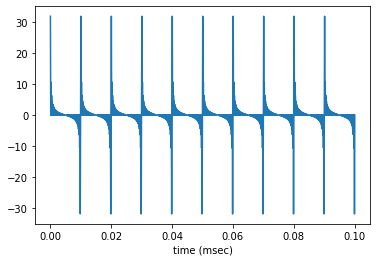

In [4]:
# parameter setting
amp = 1
sr = 10000
dur = 0.5

F0 = 100
Fend = int(sr/2)  

phase = 0

s_all = 0
for freq in range(F0, Fend+1, F0): #100부터 5000까지 100만큼 띄면서 만들어라
  s, t, theta = phasor_sine(amp, sr, dur, freq, phase)
  s_all += s

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t[0:1000], s_all[0:1000]); 
ax.set_xlabel('time (msec)')
ipd.Audio(s_all, rate=sr)
#한 줄처럼의 pulse가 여러개 있어서 pulse train.
#f0을 100이 아니라 200으로 하면 엄청 촘촘하게 돼서 더 높은 소리 남.

Filtering source through vocal tract: Formants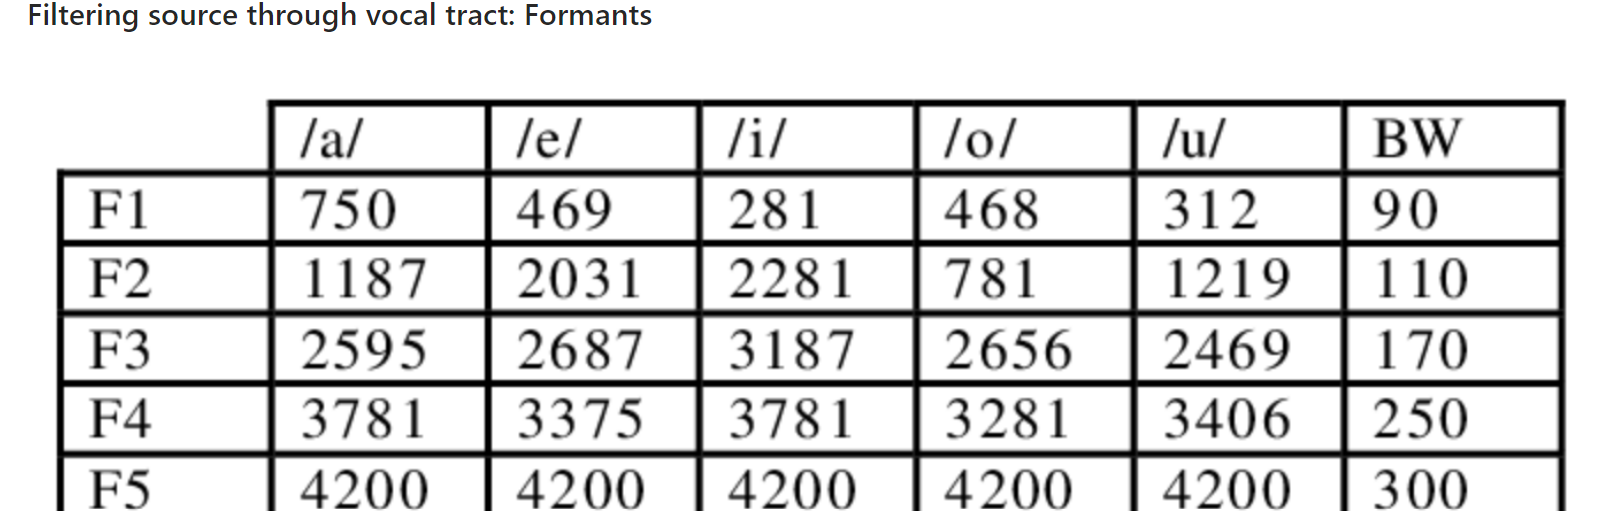



In [ ]:
#f1,f2가 모음을 특정 짓는 데 결정적인 역할을 함.

입모양 자체가 source. source>filter>output signal. 

다시말해 구강을 통해서 어떻게 특정 소리가 나고 더 강화되는 지 파악.

750, 1187 등등 이런 데에서 세게 들리면 그게 a다 이런 소리임.

frequency를 x축으로 하는 것에서 750에서 튀어나오고, 1187에서 튀어나오고 이런다는 뜻 이 spectrum이 결국 filter


ㅇ ㅏ그니까 frequency x축으로 쭉 세로줄 있는 그래프에서 위 스펙트럼 모양대로 carving해서 소리 만드는 것.

BW=band width. 폭이 좁은 산.

signal -> filter -> output
이때 a, b filter있는데 전자는 iir 후자는 fir임

주파수의 관점에서 어떤 부분을 더 강화해야하는지 f1, f2이걸로 나타남. 그래서 이 값들을 filter의 a,b coefficient로 만들어놈. 쉽게 쓰라고. 

In [5]:
def hz2w(F, sr):
    NyFreq = sr/2;
    w = F/NyFreq *np.pi;
    return w

def resonance (srate, F, BW): #어디가 resonance이고, 산 크기 얼마난지
    a2 = np.exp(-hz2w(BW,srate))
    omega = F*2*np.pi/srate
    a1 = -2*np.sqrt(a2)*np.cos(omega)
    a = np.array([1, a1, a2])
    b = np.array([sum(a)])
    return a, b

In [ ]:
#->모음 만들기

In [6]:
s = s_all
#pulse train을 다시 s로 받기

In [8]:
from scipy.signal import lfilter

RG = 0  # RG is the frequency of the Glottal Resonator
BWG = 100  # BWG is the bandwidth of the Glottal Resonator
#0에다가 산을 만들어서 오른쪽이 쭉 내려올 수 있게 해라.그렇게 깎아 내려라.
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

#부드러운 소리가 됨.

In [9]:
RG = 750  # RG is the frequency of the 1st Formant
BWG = 90  # BWG is the bandwidth of the 1st Formant
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [10]:
RG = 1187  # RG is the frequency of the 2nd Formant
BWG = 110  # BWG is the bandwidth of the 2nd Formant
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [11]:
RG = 2595  # RG is the frequency of the 3rd Formant
BWG = 170  # BWG is the bandwidth of the 3rd Formant
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [12]:
RG = 3781  # RG is the frequency of the 4th Formant
BWG = 250  # BWG is the bandwidth of the 4th Formant
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [13]:
s = lfilter(np.array([1, -1]), np.array([1]), s) #a coeffecient 1로 해서 아무것도 안건드리느 것.
#b만 건드는데, 입술 모양 효과적으로 소리나게 만듦.
ipd.Audio(s, rate=sr)

#성대 소리에서 입술을 거쳐 사람 소리로 만듦. 

#source는 다양한 주파수를 가지고 있는 phasor들의 합으로 되어있다.

LPC filter coefficients


*   모음 분석에만 이용
*   H * Y = X (X는 pulse train)


*   signal Y를 FIR 하면 pulse train X가 되는 H의 coefficients를 구하는 것임

signal y= 모음이라고 생각하면 됨.
*   즉, Y = 1/H * X 에서 H의 coefficients 구하는 것과 동일


*  X의 관점에서 lfilter의 a 계수값 추정하는 것임





푸리에를 이용하면 어떤 주파수 성분이 얼마나 있는지 알 수 있음

유사하게 LPC로도 할 수 있음. 근데 얘는 모음에만 적용됨.

In [14]:
# from google.colab import files
# fn = files.upload()
import os
url = "https://raw.githubusercontent.com/hsnam95/class2022Spring/main/aeiou.wav"
os.system("curl " + url + " > aeiou.wav")

s, sr = librosa.load('aeiou.wav')
ipd.Audio(s[7000:12000], rate=sr)

#거꾸로 가서 소리를 파악해보는 것임

In [15]:
import scipy
M = int(sr/1000+4) # Number of LPC coefficnets
a = librosa.lpc(s[7000:12000], M)
#M은 몇개의 coefficient 구할까 이런 뜻. a는 어떤 소리에 대해서 이야기할까

Spectrum plotted from LPC coefficients

(0.0, 5000.0)

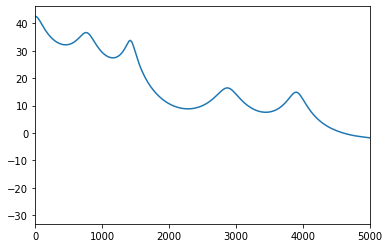

In [16]:
w, h = scipy.signal.freqz(1, a)
plt.plot (w*sr/(2*np.pi), 20*np.log10(np.abs(h)))
plt.xlim((0,5000))

#y축이 데시벨, x축이 frequency
#그 산봉우리 만든 그래프

In [ ]:
#--> LPC coefficients 를 통해 formants를 정확히 수학적으로 구할 수 있다.

Formants & Bandwidths computed from LPC coeffcients 

In [17]:
BWcutoff = 2000;
F = np.sort(np.angle(np.roots(a)))
order = np.argsort(np.angle(np.roots(a)))
F = F*sr/(2*np.pi);

BW = -2*np.log(abs(np.roots(a)))*sr/(2*np.pi);
BW = BW[order];

idx = [i for i in range(F.shape[0]) if (F[i] > 0) & (BW[i] < BWcutoff) ]

print(F[idx])
print(BW[idx])

[  773.0751  1427.4038  2873.7573  3904.3184  4630.678   5151.7295
  7404.265   7795.8794  8694.367   9274.946  10049.233 ]
[ 229.41571  130.27097  307.47186  229.12651 1215.9471   542.4114
  202.3538   303.34442 1630.4275   210.64189 1169.2583 ]
